# **Линейная регрессия**

## **Важная информация**

**Для правильного воспроизведения результатов** решения задач:

* Рекомендуется придерживаться имеющего в заданиях кода в исходной последовательности. Для этого при решении задач **восстановите недостающие фрагменты кода, которые отмечены символом** `...` (Ellipsis).

* Если класс, функция или метод предусматривает параметр random_state, всегда указывайте **random_state=RANDOM_STATE**.

* Для всех параметров (кроме random_state) класса, функции или метода **используйте значения по умолчанию, если иное не указано в задании**.

**Если скорость обучения слишком низкая**, рекомендуется следующее:

* В модели или/и GridSearchCV поменяйте значение параметра n_jobs, который отвечает за параллелизм вычислений.

* Воспользуйтесь вычислительными ресурсами Google Colab или Kaggle.

***Использовать GPU не рекомендуется, поскольку результаты обучения некоторых моделей могут отличаться на CPU и GPU.***

После выполнения каждого задания **ответьте на вопросы в тесте.**

**ВНИМАНИЕ:** **После каждого нового запуска ноутбука** перед тем, как приступить к выполнению заданий, проверьте настройку виртуального окружения, выполнив код в ячейке ниже.

In [3]:
# Код для проверки настройки виртуального окружения

import sys
from importlib.metadata import version

required = {
    'python': '3.11.x',
    'numpy': '1.26.4',
    'pandas': '2.1.4',
    'scikit-learn': '1.7.0',
    'statsmodels': '0.14.4',
    'matplotlib': '3.8.0',
    'seaborn': '0.13.2'
}

print(f'{"Компонент":<15} | {"Требуется":<12} | {"Установлено":<12} | {"Соответствие"}')
print('-' * 62)

environment_ok = True
for lib, req_ver in required.items():
    try:
        if lib == 'python':
            inst_ver = sys.version.split()[0]
            status = '✓' if sys.version_info.major == 3 and sys.version_info.minor == 11 else f'x (требуется {req_ver})'
        else:
            inst_ver = version(lib)
            if inst_ver == req_ver:
                status = '✓'
            else:
                environment_ok = False
                status = f'x (требуется {req_ver})'
    except:
        environment_ok = False
        inst_ver = '-'
        status = 'x (не установлена)'
    print(f'{lib:<15} | {req_ver:<12} | {inst_ver:<12} | {status}')

print('\nРезультат проверки: ', 
      '✓\nВсе версии соответствуют требованиям' 
      if environment_ok else 
      'x\nВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!\n'
      'Для решения проблемы обратитесь к инструкции по настройке виртуального окружения')

Компонент       | Требуется    | Установлено  | Соответствие
--------------------------------------------------------------
python          | 3.11.x       | 3.11.8       | ✓
numpy           | 1.26.4       | 1.26.4       | ✓
pandas          | 2.1.4        | 2.1.4        | ✓
scikit-learn    | 1.7.0        | 1.7.0        | ✓
statsmodels     | 0.14.4       | 0.14.5       | x (требуется 0.14.4)
matplotlib      | 3.8.0        | 3.8.0        | ✓
seaborn         | 0.13.2       | 0.13.2       | ✓

Результат проверки:  x
ВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!
Для решения проблемы обратитесь к инструкции по настройке виртуального окружения


## **Импорт библиотек и вспомогательные функции**

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn import datasets

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white

In [6]:
RANDOM_STATE = 42

In [7]:
def metrics_report(y_true, y_pred):
    """
    Выводит отчёт с основными метриками качества регрессии.
    Округляет до 4-х знаков после запятой и выводит значения R2 (коэффициент детерминации), RMSE (среднеквадратичная ошибка) и MAPE (средняя абсолютная процентная ошибка) для оценки качества предсказаний.

    Аргументы:
        y_true (numpy.ndarray): Истинные значения целевой переменной.
        y_pred (numpy.ndarray): Предсказанные значения целевой переменной.
    """
    print(f'R2 score: {r2_score(y_true, y_pred):.4f}')
    print(f'RMSE: {mean_squared_error(y_true, y_pred)**0.5:.4f}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred):.4f}')

In [8]:
def r2_adj_score(y_true, y_pred, k):
    """
    Рассчитывает скорректированный коэффициент детерминации (Adj. R²).
    
    Аргументы:
        y_true (numpy.ndarray): Истинные значения целевой переменной.
        y_pred (numpy.ndarray): Предсказанные значения целевой переменной.
        k (int): Количество факторов.

    Возвращает:
        float: Значение скорректированного коэффициента детерминации.
    """
    return 1 - (1 - r2_score(y_true, y_pred)) * (len(y_true) - 1) / (len(y_true) - k - 1)

## **Практическая часть**

### **Значимость коэффициентов линейной регрессии**

Линейная регрессия позволяет проверять статистические гипотезы, связанные с влиянием независимых переменных (факторов) на зависимую переменную. В частности, гипотезу о значимости коэффициентов регрессии:

* Нулевая гипотеза ($H_0$): Коэффициент при факторе $i$ равен нулю: $\beta_i = 0$ (нет влияния).

* Альтернативная гипотеза ($H_1$): $\beta_i \ne 0$ (фактор значимо влияет на зависимую переменную).

* Метод проверки: t-тест для коэффициентов (если p-value < $\alpha$ (обычно 0.05), отвергаем $H_0$).

### **Коэффициент детерминации ($R^2$)**

**Коэффициент детерминации** ($R^2$) — это статистическая мера, которая показывает, насколько хорошо модель линейной регрессии объясняет вариацию (дисперсию) зависимой переменной. $R^2$ вычисляется по формуле:

$$R^2=1−​\frac{SS_{res}}{​SS_{total}}$$

где $SS_{res}$​ — сумма квадратов остатков (необъяснённая дисперсия), $SS_{total}$​ — общая сумма квадратов (общая дисперсия зависимой переменной).

Чем ближе значение $R^2$ к 1, тем модель лучше объясняет изменения зависимой переменной ($0 \le R^2 \le 1$).

Пример: если $R^2=0.75$, то это означает, что 75% изменений зависимой переменной объясняются моделью, а 25% — случайными факторами.

### ***Задание 1***

Сгенерируйте две переменные:

* `feature` (объясняющий фактор): значение некоторой характеристики товара.

* `cost` (целевая/объясняемая переменная): стоимость товара.

Обучите две модели линейной регрессии на `feature` (предобработка данных не требуется):

* `sk_reg` — модель LinearRegression из библиотеки sklearn (scikit-learn).

* `sm_reg` — модель OLS из библиотеки statsmodels.

Сравните значения коэффициентов обученных моделей `sk_reg` и `sm_reg`, и для модели `sm_reg` проверьте статистическую значимость коэффициентов с помощью метода [summary](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.summary.html).

Рассчитайте $R^2$ для обеих моделей.

**ВНИМАНИЕ:** Перед обучением линейной регрессии в statsmodels (`sm_reg`) необходимо добавить константу к `feature` с помощью метода [add_constant](https://tedboy.github.io/statsmodels_doc/generated/statsmodels.api.add_constant.html).

*Библиотека statsmodels больше ориентирована на статистический анализ и проверку гипотез, тогда как scikit-learn ориентирован на выполнение множества задач в рамках машинного обучения, включая предобработку данных, обучение широкого спектра не классических моделей (в отличие от statsmodels), пайплайны (конвейеры) и многое другое.*

In [9]:
# Сгенерируйте переменные feature и cost
# Переменная rng позволит зафиксировать RANDOM_STATE при генерации случайных чисел в numpy

rng = np.random.RandomState(RANDOM_STATE)

feature = rng.uniform(0, 100, 1000)
cost = feature + rng.normal(3000, 500, 1000)

feature = feature.reshape(-1, 1)

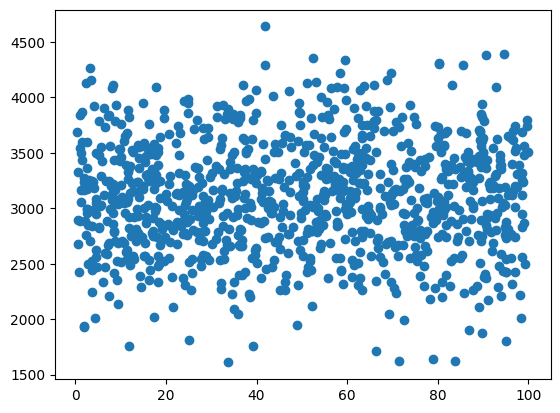

In [10]:
# Постройте точечную диаграмму (scatter plot) cost ~ feature

plt.scatter(
    x=feature,
    y=cost
)
plt.show()

In [11]:
# Обучите модель sk_reg на всем наборе данных и рассмотрите коэффициенты обученной модели
sk_reg = LinearRegression().fit(feature, cost)
y_pred = sk_reg.predict(feature)

print("=== Основные метрики ===")
metrics_report(cost, y_pred)

print("\n=== Скорректированный R² ===")
print(f"Adj. R²: {r2_adj_score(cost, y_pred, k=feature.shape[1]):.4f}")

=== Основные метрики ===
R2 score: 0.0002
RMSE: 493.7023
MAPE: 0.1344

=== Скорректированный R² ===
Adj. R²: -0.0008


In [12]:
# Посчитайте метрики качества модели sk_reg

print(sk_reg.coef_)

[0.22607418]


In [13]:
#%pip install -U scipy statsmodels

In [14]:
# Обучите модель sm_reg на всем наборе данных и рассмотрите вывод метода summary
# Перед обучением sm_reg необходимо добавить константу к feature с помощью метода add_constant
import statsmodels.api as sm
feature_const = sm.add_constant(feature)
sm_reg = OLS(cost,feature_const).fit()
print(sm_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1784
Date:                Fri, 24 Oct 2025   Prob (F-statistic):              0.673
Time:                        21:47:07   Log-Likelihood:                -7620.9
No. Observations:                1000   AIC:                         1.525e+04
Df Residuals:                     998   BIC:                         1.526e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3087.3901     30.541    101.091      0.0

In [15]:
# Посчитайте метрики качества модели sm_reg

y_pred = sm_reg.predict(feature_const)

print("=== Основные метрики ===")
metrics_report(cost, y_pred)

print("\n=== Скорректированный R² ===")
print(f"Adj. R²: {r2_adj_score(cost, y_pred, k=feature_const.shape[1]):.4f}")

=== Основные метрики ===
R2 score: 0.0002
RMSE: 493.7023
MAPE: 0.1344

=== Скорректированный R² ===
Adj. R²: -0.0018


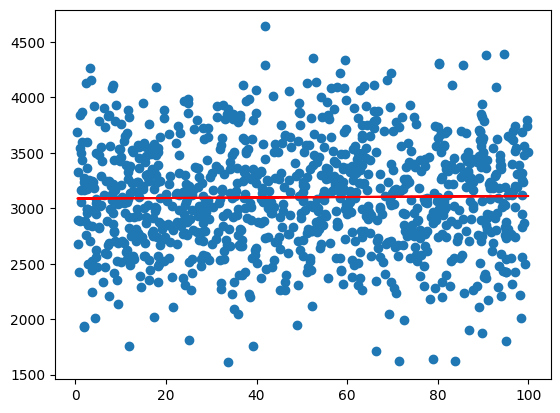

In [16]:
# Постройте точечную диаграмму cost ~ feature и нанесите на нее предсказания одной из моделей

plt.scatter(
    x=feature,
    y=cost
)
plt.plot(feature, y_pred, color='r')
plt.show()

## Задание 1
Выберите все верные утверждения из списка.
Модели обладают высокой объясняющей способностью.
Связи между объясняющей и объясняемой переменными нет на уровне значимости 5%.
Коэффициенты двух моделей равны с точностью до 0.0001.
R² двух моделей равен с точностью до 0.0001.




**Связи между объясняющей и объясняемой переменными нет на уровне значимости 5%.**  
**R² двух моделей равен с точностью до 0.0001.**

**Фактор feature статистически незначим, так как его p-value больше 0.05.**

### **Экзогенность факторов линейной регрессии**

Одно из ключевых предположений линейной регрессии — экзогенность, которая подразумевает, что объясняющие переменные (факторы) не коррелируют с ошибками: 

$$\mathbb{E}[\varepsilon_i|X]=0 \; \forall i$$

где $\mathbb{E}$ — условное математическое ожидание, $\varepsilon_i$ — ошибка для i-го наблюдения, $X$ — матрица всех объясняющих факторов.

**Если предположение об экзогенности нарушается, то оценки регрессии могут стать смещенными и несостоятельными.**

**Примеры нарушения экзогенности:**

* Целевая переменная влияет на фактор. Например, в ситуации, когда моделируется влияние образования на доход, обратная причинность заключается в том, что более высокий доход также позволяет инвестировать в дополнительное образование.

* Фактор и целевая переменная определяются одновременно. Например, в модели спроса и предложения, цена и количество определяются одновременно.

* **Смещение пропущенной переменной (omitted-variable bias)**: существует скрытый фактор $t$, который влияет как на фактор $x$, так и на целевую переменную $f$, но не включен в модель.

Схема смещения пропущенной переменной:


```
                         +-----------------------+
            +----------->| Фактор x              |
            |            +-----------+-----------+
            |                        |            
+-----------+-----------+            |            
| Скрытый фактор t      |            |            
+-----------+-----------+            |            
            |                        V            
            |            +-----------+-----------+
            +----------->| Целевая переменная f  |
                         +-----------------------+
```

В ситуации смещения пропущенной переменной наблюдаемая корреляция между $x$ и $f$ может быть частично или полностью обусловлена влиянием $t$, а не прямой причинно-следственной связью между $x$ и $f$. Если $t$ не включен в модель, его влияние будет поглощено членом ошибки, что приведет к корреляции между фактором $x$ и ошибкой $\varepsilon$. Это нарушает предположение строгой экзогенности и делает оценки регрессии смещенными и несостоятельными.

### **Задание 2**

Сгенерируйте три переменные для моделирования ситуации смещения пропущенной переменной:

* Скрытый ненаблюдаемый фактор `t`.

* Фактор `x`, на который влияет `t`.

* Целевая переменная `f`, на которую влияют факторы `t` и `x`.

Обучите две модели линейной регрессии statsmodels (OLS):

* `reg_biased` — f ~ x (модель предсказывает `f` по значениям `x`).

* `reg_unbiased` — f ~ x + t (модель предсказывает `f` по значениям `x` и `t`).

Выведите summary для `reg_biased` и `reg_unbiased`, сравните коэффициенты при факторах в моделях `reg_biased` и `reg_unbiased` с истинными.

In [17]:
# Сгенерируйте скрытый фактор t
# Сгенерируйте фактор x, на который влияет t
# Сгенерируйте целевую переменную f, на которую влияют факторы t и x
# Истинные коэффициенты при факторах:
#   x: 2
#   t: -4
# Переменная rng позволит зафиксировать RANDOM_STATE при генерации случайных чисел в numpy

rng = np.random.RandomState(RANDOM_STATE)

t = rng.normal(0, 1, 1000)
x = 0.5 * t + rng.normal(0, 0.5, 1000)
f = 2 * x - 4 * t + rng.normal(0, 1, 1000)

In [18]:
# Обучите модель f ~ x и выведите summary
X_biased = sm.add_constant(x)
reg_biased = OLS(f,X_biased).fit()
print(reg_biased.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     190.8
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           7.79e-40
Time:                        21:47:07   Log-Likelihood:                -2515.1
No. Observations:                1000   AIC:                             5034.
Df Residuals:                     998   BIC:                             5044.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1049      0.095      1.105      0.2

In [19]:
# Обучите модель f ~ x + t и выведите summary

X_unbiased = sm.add_constant(np.column_stack([x, t]))
reg_unbiased = OLS(f,X_unbiased).fit()
print(reg_unbiased.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     5009.
Date:                Fri, 24 Oct 2025   Prob (F-statistic):               0.00
Time:                        21:47:07   Log-Likelihood:                -1401.5
No. Observations:                1000   AIC:                             2809.
Df Residuals:                     997   BIC:                             2824.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.031      0.197      0.8

In [20]:
# Сравните коэффициенты при факторах в моделях reg_biased и reg_unbiased с истинными

print('Истинный коэффициент при x: 2')
print('Истинный коэффициент при t: - 4')

print(f'Смещенный коэффициент при x (f ~ x): {-1.9121}')

print(f'Несмещенный коэффициент при x (f ~ x + t): {1.9796}')
print(f'Несмещенный коэффициент при t (f ~ x + t) {-3.9680}')

Истинный коэффициент при x: 2
Истинный коэффициент при t: - 4
Смещенный коэффициент при x (f ~ x): -1.9121
Несмещенный коэффициент при x (f ~ x + t): 1.9796
Несмещенный коэффициент при t (f ~ x + t) -3.968


## Задание 2
Выберите все верные утверждения из списка.

Основное последствие нарушения предположения об экзогенности факторов в линейной регрессии состоит в том, что R² модели уменьшается, что говорит о снижении точности модели.  
**В модели reg_biased коэффициент при x значительно отличается от истинного значения 2, что является признаком смещения.**  
**Включение t привело к тому, что оценка коэффициента x стала близка к истинным значениям, что указывает на уменьшение смещения.**  
После добавления в регрессию скрытого фактора t, R² уменьшился, что говорит о неэффективности включения t.  

Истинный коэффициент при x в регрессии f ~ x равен 2. Рассмотрите summary для модели reg_biased и выберите из списка фактическое значение коэффициента при факторе x, полученное после обучения.

Результат округлён до 4-х знаков после запятой.

**-1.9121**

Истинный коэффициент при x в регрессии f ~ x + t равен 2. Рассмотрите summary для модели reg_unbiased и выберите из списка фактическое значение коэффициента при факторе x, полученное после обучения.

Результат округлён до 4-х знаков после запятой.

**1.9796**

### **Предобработка данных**

**Предобработка данных** — это важнейший аспект машинного обучения, который напрямую влияет на качество, точность и производительность моделей ML. Данные в сыром виде часто бывают неполными или плохо структурированными, и без их предварительной подготовки построение эффективных моделей практически невозможно.

**Основные этапы предобработки данных:**

1. **Сбор и интеграция данных.** Загрузка данных из одного или нескольких источников и объединение их в один датасет (или несколько датасетов).

2. **Первичный анализ данных.** Подсчет статистических характеристик датасета, построение графиков и оценка корреляционных зависимостей между переменными.

3. **Очистка данных.** Удаление дубликатов и исправление явных ошибок (опечатки, отрицательный возраст).

4. **Обработка пропусков.** 

* Удаление строк с пропусками.

* Удаление столбцов с пропусками.

* Заполнение описательными характеристиками (средним/модой/медианой).

* Заполнение прогнозом (KNN, Regression, MICE).

5. **Обработка категориальных признаков.**

* One-Hot Encoding.

* Ordinal/Label Encoding.

6. **Разделение данных.** Разделение данных на обучающую, валидационную и тестовую выборки.

7. **Масштабирование числовых (количественных) признаков.**

* StandardScaler.

* MinMaxScaler.

*Это лишь основные этапы предобработки данных. На практике количество существующих методов обработки данных намного больше, а структура и порядок этапов **зависит от решаемой задачи***.

**Необходимым условием правильного выполнения последующих заданий является правильная предобработка данных.**

Процедура предобработки указывается в заданиях курса и, как правило, включает в себя считывание данных, выделение целевой переменной, обработку категориальных признаков с помощью One-Hot кодирования, разделение данных на обучающую (train) и тестовую (test) выборки, а также масштабирование числовых признаков с помощью стандартизации (Standard Scaler).

### **Датасет *Housing Prices Dataset***

**Для решения заданий 3 — 9 рассмотрим датасет [Housing Prices Dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset).**

Набор данных предназначен для решения задачи регрессии — прогнозирования цены дома на основе его характеристик.

Целевая переменная — price (цена дома).

Датасет содержит признаки:

* Площадь (area).

* Количество комнат (bedrooms, bathrooms).

* Количество этажей (stories).

* Количество парковочных мест (parking).

* Близость к главной дороге, категориальный (mainroad).

* Уровень меблировки, категориальный (furnishingstatus).

* Наличие гостевой комнаты и подвала, бинарные (guestroom, basement).

* Наличие водонагревателя и кондиционера, бинарные (hotwaterheating, airconditioning).

* Находится ли дом в предпочтительном районе (prefarea).

### ***Задание 3***

Выполните предобработку данных:

1. **read_csv**: считайте набор данных стоимости жилья и выделите объясняемый фактор в отдельную переменную.

2. **OneHotEncoder:** закодируйте категориальные переменные значениями 0 и 1.

3. **train_test_split:** разделите датасет на обучающую (60%) и тестовую (40%).

4. **StandardScaler:** масштабируйте количественные переменные.

Используя метод describe, рассмотрите статистические характеристики исходного датасета и подготовленных выборок.

In [21]:
# Считайте набор данных

df_housing = pd.read_csv('house_prices.csv')
df_housing

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


#### **Как определить тип признака с помощью метода [info](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html)**

Метод info (pandas) выводит тип данных (dtype) каждого столбца, но не классифицирует их явно на количественные и категориальные. Однако по dtype можно сделать предположение:

* int, float — как правило, количественные, но могут быть и категориальными (например, бинарный признак 0/1 или порядковый код категории).

* object, string, bool, category — как правило, категориальные.

**ВНИМАНИЕ:** В используемом датасете int64 — количественные, object —категориальные.

In [22]:
# Используя метод info, определите типы признаков

df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [23]:
# Создайте списки количественных и категориальных переменных (не включая целевую переменную)

housing_num_feat = ['area','bedrooms','bathrooms','stories','parking']
housing_cat_feat = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea','furnishingstatus']

#### **Что показывает метод [describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)**

* **Для числовых (количественных) признаков**

    * count — количество не пропущенных значений.

    * mean — среднее арифметическое.

    * std — стандартное отклонение.

    * min — минимальное значение.

    * 25% — первый квартиль (25-й процентиль).

    * 50% — медиана (50-й процентиль).

    * 75% — третий квартиль (75-й процентиль).

    * max — максимальное значение.

* **Для категориальных признаков**

    * count — количество не пропущенных значений.

    * unique — число уникальных значений.

    * top — самое часто встречающееся значение.
    
    * freq — частота значения top.

In [24]:
# Посчитайте статистические характеристики количественных признаков

df_housing[housing_num_feat].describe()

,area,bedrooms,bathrooms,stories,parking
count,545.000000,545.000000,545.000000,545.000000,545.000000
mean,5150.541284,2.965138,1.286239,1.805505,0.693578
std,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,6360.000000,3.000000,2.000000,2.000000,1.000000
max,16200.000000,6.000000,4.000000,4.000000,3.000000


In [25]:
# Посчитайте статистические характеристики категориальных признаков

df_housing[housing_cat_feat].describe()

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,545,545,545,545,545,545,545
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,468,448,354,520,373,417,227


In [26]:
# Выделите объясняемый фактор в отдельную переменную

X_housing, y_housing =  df_housing[housing_num_feat + housing_cat_feat], df_housing['price']
X_housing.shape

(545, 12)

#### **Как использовать [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)**

OneHotEncoder в sklearn преобразует категориальные признаки в бинарные (one-hot) столбцы. 

Параметры:

* drop='first' — удаляет первый столбец для каждого признака (для избежания мультиколлинеарности).

* sparse=False — возвращает результат в виде массива numpy вместо разреженной матрицы.

*Более продвинутые способы использования — в ColumnTransformer и Pipeline, будут рассмотрены в следующих домашних заданиях.*

In [27]:
# Закодируйте категориальные признаки числами 0 и 1 с помощью OneHotEncoder

housing_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')

X_housing_encoded = housing_encoder.fit_transform(X_housing[housing_cat_feat])
X_housing = X_housing.join(X_housing_encoded)
X_housing = X_housing.drop(columns=housing_cat_feat) # Удаляем исходные столбцы после One-Hot кодирования

In [28]:
X_housing.shape

(545, 13)

#### **Как использовать [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) с обучающей и тестовой выборками**

**Основные принципы:**

* Обучайте (fit) скейлер только на обучающих данных.

* Применяйте преобразование (transform) к обучающим и тестовым данным.

* Не обучайте scaler на полной выборке (до разделения), это приведет к ["утечке информации" (data leakage)](https://scikit-learn.org/stable/common_pitfalls.html#data-leakage).

* [Используйте одинаковое преобразование для train и test](https://scikit-learn.org/stable/common_pitfalls.html#inconsistent-preprocessing).

*Более продвинутые способы использования — в ColumnTransformer и Pipeline, будут рассмотрены в следующих домашних заданиях.*

In [29]:
# С помощью train_test_split разделите датасет на обучающую (60%) и тестовую (40%) выборки с перемешиванием, без стратификации
# Не забудьте зафиксировать RANDOM_STATE

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(
    X_housing, y_housing, test_size=0.4, random_state=RANDOM_STATE, shuffle=True, stratify=None
)

#### **Как использовать [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) с обучающей и тестовой выборками**

Основной принцип:

* Обучаем (fit) скейлер только на обучающих данных

* Применяем преобразование (transform) к обучающим и тестовым данным

* Нельзя обучать scaler на полной выборке (до разделения), это приведет к ["утечке информации" (data leakage)](https://scikit-learn.org/stable/common_pitfalls.html#data-leakage)

* [Используем одинаковое преобразование для train и test](https://scikit-learn.org/stable/common_pitfalls.html#inconsistent-preprocessing)

*Более продвинутые способы использования — в ColumnTransformer и Pipeline, будут рассмотрены в следующих домашних заданиях.*

In [30]:
# Масштабируйте количественные признаки
#   train -> fit_transform
#   test -> transform

housing_scaler = StandardScaler().set_output(transform='pandas')

X_housing_train_scaled = X_housing_train.copy()
X_housing_train_scaled[housing_num_feat] = housing_scaler.fit_transform(X_housing_train_scaled[housing_num_feat]) # fit_transform

X_housing_test_scaled = X_housing_test.copy()
X_housing_test_scaled[housing_num_feat] = housing_scaler.transform(X_housing_test_scaled[housing_num_feat]) # transform

In [31]:
# Посчитайте статистические характеристики признаков в обучающей выборке (describe)

X_housing_train_scaled.describe()

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
count,3.270000e+02,3.270000e+02,3.270000e+02,3.270000e+02,3.270000e+02,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,-1.358071e-16,-8.963268e-17,6.790355e-17,7.061969e-17,-7.876812e-17,0.850153,0.171254,0.333333,0.051988,0.318043,0.220183,0.412844,0.327217
std,1.001533e+00,1.001533e+00,1.001533e+00,1.001533e+00,1.001533e+00,0.357468,0.377308,0.472127,0.222343,0.466430,0.415005,0.493100,0.469916
min,-1.645988e+00,-2.579240e+00,-5.113055e-01,-9.226195e-01,-7.774259e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.998216e-01,-1.248938e+00,-5.113055e-01,-9.226195e-01,-7.774259e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.858738e-01,8.136403e-02,-5.113055e-01,2.793589e-01,-7.774259e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.469497e-01,8.136403e-02,-5.113055e-01,2.793589e-01,4.331373e-01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,5.228502e+00,4.072270e+00,6.176571e+00,2.683316e+00,2.854264e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
X_housing_train_scaled.shape

(327, 13)

In [33]:
# Посчитайте статистические характеристики признаков в тестовой выборке (describe)
X_housing_test_scaled.shape
X_housing_test_scaled.describe()

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.00000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,0.197653,0.087466,0.317009,0.113949,0.155485,0.87156,0.188073,0.376147,0.036697,0.311927,0.256881,0.422018,0.325688
std,1.156145,0.951421,1.256199,1.100397,1.098034,0.33535,0.391670,0.485532,0.188450,0.464346,0.437919,0.495018,0.469710
min,-1.621348,-1.248938,-0.511306,-0.922620,-0.777426,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.685038,0.081364,-0.511306,-0.922620,-0.777426,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.028529,0.081364,-0.511306,0.279359,-0.777426,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.793347,0.081364,1.717987,0.279359,1.643701,1.00000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,5.524179,4.072270,3.947279,2.683316,2.854264,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
X_housing_test_scaled.shape

(218, 13)

## ответы на задание 3  

Признак area до масштабирования обладает наибольшим средним значением среди количественных факторов.  
После применения One-Hot кодирования в датасете X_housing осталось 13 столбцов факторов (не включая целевую переменную).  
Airconditioning — категориальная БИНАРНАЯ переменная (до One-Hot кодирования).

+++

После применения StandardScaler (housing_scaler) среднее значение всех количественных переменных в обучающей выборке (X_housing_train_scaled) равно 0 с точностью до 0.1.  
После применения StandardScaler (housing_scaler) стандартное отклонение всех количественных переменных в тестовой выборке (X_housing_test_scaled) равно 1 с точностью до 0.5.

### **Скорректированный коэффициент детерминации ($Adj.\;R^2$)**

Скорректированный коэффициент детерминации ($Adj.\;R^2$) — это модификация $R^2$, которая учитывает количество факторов в модели и штрафует за добавление незначимых переменных. $Adj.\;R^2$ рассчитывается по формуле:

$$Adj.\;R^2=1−\frac{(1-R^2)(n-1)}{n-k-1}$$

где $n$ — число наблюдений, $k$ — число факторов в модели.

Если при добавлении новых переменных $R^2$ растет (не уменьшается), то $Adj.\;R^2$ может уменьшиться, если новый фактор не улучшает объясняющую способность модели.

При сравнении двух моделей с одинаковым числом признаков можно использовать как $R^2$, так и $Adj.\;R^2$. Если число признаков у двух моделей отличается, то следует использовать $Adj.\;R^2$, поскольку $R^2$ не учитывает количество признаков.

### ***Задание 4***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку **после масштабирования** из задания 3: `X_housing_train_scaled`.

На выборке `X_housing_train_scaled` обучите модель линейной регрессии statsmodels `reg_housing`, и с помощью анализа summary модели `reg_housing` (или с помощью t-теста) определите незначимые **количественные** факторы на уровне значимости 5%.

*Использовать t-тест для проверки значимости **категориальной** переменной с $k > 2$ уровней нельзя. Категориальная переменная с $k > 2$ уровнями требует проверки влияния всех уровней одновременно (например, с помощью F-теста), а не попарно. В то же время **категориальные бинарные** ($k = 2$) переменные могут быть проверены на значимость с помощью t-теста.*

Далее убедимся, что при добавлении новых незначимых признаков в линейную регрессию:

* Коэффициент детерминации $R^2$ растет (не уменьшается).

* Скорректированный коэффициент детерминации $Adj.\;R^2$ уменьшается (не увеличивается).

Добавьте в выборку `X_housing_train_scaled` 10 случайных независимых факторов и сравните, насколько изменились $R^2$ и $Adj.\;R^2$.

In [35]:
# Обучите регрессию reg_housing на обучающей выборке
# Перед обучением регрессии statsmodels необходимо добавить константу с помощью метода add_constant

X_housing_train_scaled_const = sm.add_constant(X_housing_train_scaled)
reg_housing = OLS(y_housing_train,X_housing_train_scaled_const).fit()

In [36]:
print(reg_housing.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     46.60
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           3.00e-65
Time:                        21:47:09   Log-Likelihood:                -4965.2
No. Observations:                 327   AIC:                             9958.
Df Residuals:                     313   BIC:                         1.001e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [37]:
# Определите незначимые количественные признаки на уровне значимости 5%

insignificant_num = [col for col in housing_num_feat if reg_housing.pvalues[col] > 0.05]

print("Незначимые количественные признаки (p > 0.05):", insignificant_num)

Незначимые количественные признаки (p > 0.05): ['bedrooms']


In [38]:
# Сгенерируйте случайные факторы и добавьте их в обучающую выборку
# Не забудьте зафиксировать RANDOM_STATE

rng = np.random.RandomState(RANDOM_STATE)

noise = pd.DataFrame(
        rng.normal(0, 1, size=(X_housing_train_scaled.shape[0], 10)),
        index=X_housing_train_scaled.index
)

X_housing_train_scaled_noise = X_housing_train_scaled.join(noise)

In [39]:
# Обучите регрессию reg_housing на обучающей выборке со случайными факторами
# Перед обучением регрессии statsmodels необходимо добавить константу с помощью метода add_constant

X_housing_train_scaled_noise_const = sm.add_constant(X_housing_train_scaled_noise)
reg_housing_noise = OLS(y_housing_train,X_housing_train_scaled_noise_const).fit()

In [40]:
# Сравните, насколько изменились R² и Adj. R² после добавления случайных факторов

print(reg_housing_noise.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     26.31
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           8.42e-59
Time:                        21:47:09   Log-Likelihood:                -4961.8
No. Observations:                 327   AIC:                             9972.
Df Residuals:                     303   BIC:                         1.006e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [41]:
# Сравните, насколько изменились R² и Adj. R² после добавления случайных факторов
r2_old    = reg_housing.rsquared
adjr2_old = reg_housing.rsquared_adj

r2_new    = reg_housing_noise.rsquared
adjr2_new = reg_housing_noise.rsquared_adj

print(f'R²        : {r2_old:.4f} → {r2_new:.4f}  (Δ = {r2_new - r2_old:+.4f})')
print(f'Adj. R²   : {adjr2_old:.4f} → {adjr2_new:.4f}  (Δ = {adjr2_new - adjr2_old:+.4f})')

R²        : 0.6594 → 0.6664  (Δ = +0.0070)
Adj. R²   : 0.6452 → 0.6411  (Δ = -0.0042)


## Ответы на 4 задание   
bedrooms       **0.224**   
R²(reg_housing_noise) - R²(reg_housing) = 0.0070  
**-0.0042**

### ***Задание 5***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку **после масштабирования** из задания 3: `X_housing_train_scaled`, `y_housing_train`.

* Тестовую выборку **после масштабирования** из задания 3: `X_housing_test_scaled`, `y_housing_test`.

Обучите модель линейной регрессии sklearn с L2-регуляризацией (Ridge) `ridge_housing` с оптимальными гиперпараметрами, подобрав их с помощью GridSearchCV.

Используя абсолютные коэффициенты (по модулю) обученной модели `ridge_housing` определите наиболее влиятельный **количественный** признак.

Обучите вторую Ridge модель `ridge_housing_area` с оптимальными гиперпараметрами (оптимальные гиперпараметры подберите заново, с помощью GridSearchCV) только на одном параметре — площади (area).

Сравните $Adj.\;R^2$ обученных моделей, используя функцию r2_adj_score.

#### **Как использовать [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) для подбора оптимальных параметров модели**

GridSearchCV выполняет перебор всех возможных комбинаций параметров из заданной сетки с кросс-валидацией и обучает модель для каждой такой комбинации. По результатам перебора GridSearchCV выбирает модель, которая оказалась наилучшей с точки зрения заданной метрики обучения (по умолчанию для линейной регрессии — Negative Root Mean Squared Error).

**ВНИМАНИЕ:** Оптимальными гиперпараметрами обучения будем считать те, которые привели к обучению наилучшей модели при переборе с помощью GridSearchCV.

In [42]:
# Подберите оптимальные гиперпараметры обучения ridge_housing с помощью GridSearchCV на всех факторах


# Определяем сетку гиперпараметров обучения и количество фолдов
params = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0], 
    'solver': ['saga', 'svd', 'lsqr']
}
cv = 5

# Создаем объект GridSearchCV с указанием модели, сетки параметров и количеством фолдов (5)
cv_ridge_housing = GridSearchCV(
    estimator=Ridge(random_state=RANDOM_STATE),
    param_grid=params,
    cv=cv
)

# Запускаем перебор гиперпараметров и обучение моделей
cv_ridge_housing.fit(X_housing_train_scaled, y_housing_train)

# Посчитаем метрику обучения и оптимальные гиперпараметры лучшей модели
print(f'Best score is {cv_ridge_housing.best_score_}, best parameters are {cv_ridge_housing.best_params_}')

Best score is 0.5708382839648299, best parameters are {'alpha': 10.0, 'solver': 'svd'}


In [43]:
# Обучите ridge_housing с оптимальными параметрами на всех факторах
# Не забудьте зафиксировать RANDOM_STATE

ridge_housing = Ridge(**cv_ridge_housing.best_params_, random_state=RANDOM_STATE).fit(X_housing_train_scaled, y_housing_train)

In [44]:
# Используя коэффициенты ridge_housing, определите наиболее влиятельный количественный признак

housing_coefs = pd.DataFrame(
    {'coef': ridge_housing.coef_},
    index=ridge_housing.feature_names_in_
)
housing_coefs['significance'] = housing_coefs['coef'].abs()
housing_coefs.sort_values('significance')

,coef,significance
bedrooms,89039.693154,89039.693154
furnishingstatus_semi-furnished,-101748.332993,101748.332993
parking,225485.124817,225485.124817
guestroom_yes,314395.620575,314395.620575
stories,329241.459776,329241.459776
mainroad_yes,333971.917620,333971.917620
basement_yes,397735.568371,397735.568371
bathrooms,400426.055302,400426.055302
prefarea_yes,405587.685240,405587.685240
furnishingstatus_unfurnished,-414506.090067,414506.090067


In [45]:
most_influential = housing_coefs.loc[housing_num_feat].idxmax()[0]
print("Наиболее влиятельный количественный признак:", most_influential)

Наиболее влиятельный количественный признак: area


In [46]:
# Посчитайте Adj. R² для ridge_housing на тестовой выборке
n = X_housing_test_scaled.shape[0]
k = len(ridge_housing.feature_names_in_) # Количество факторов
r2_test = r2_score(y_housing_test, ridge_housing.predict(X_housing_test_scaled))
r2_adj = 1 - (1 - r2_test) * (n - 1) / (n - k - 1)
print("Adj. R² на тестовой выборке:", r2_adj)

Adj. R² на тестовой выборке: 0.646278766809206


In [47]:
# Обучите ridge_housing_area с оптимальными гиперпараметрами только на одном параметре — площади (area)
# Оптимальные гиперпараметры подберите заново, с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0], 
    'solver': ['saga', 'svd', 'lsqr']
}
cv = 5

cv_ridge_housing_area = GridSearchCV(
    estimator=Ridge(random_state=RANDOM_STATE),
    param_grid=params,
    cv=cv
)

X_area_train = X_housing_train_scaled[['area']]
X_area_test  = X_housing_test_scaled[['area']]

# Запускаем перебор гиперпараметров и обучение моделей
cv_ridge_housing_area.fit(X_area_train, y_housing_train)

ridge_housing_area = Ridge(**cv_ridge_housing_area.best_params_, random_state=RANDOM_STATE).fit(X_area_train, y_housing_train)

In [48]:
# Посчитайте Adj. R² для ridge_housing_area на тестовой выборке

n = X_area_test.shape[0]
k = len(ridge_housing_area.feature_names_in_)      # = 1 (area)

r2_area = r2_score(y_housing_test, ridge_housing_area.predict(X_area_test))
r2_adj_area = 1 - (1 - r2_area) * (n - 1) / (n - k - 1)

print("Adj. R² на тестовой выборке (модель только по area):", r2_adj_area)

Adj. R² на тестовой выборке (модель только по area): 0.2595371747013857


In [49]:
print(f'Adj. R²   : {r2_adj:.4f} → {r2_adj_area:.4f}  (Δ = {r2_adj_area - r2_adj:+.4f})')

Adj. R²   : 0.6463 → 0.2595  (Δ = -0.3867)


'alpha': 10.0

### Выберите наиболее влиятельный количественный признак из списка.

area

### Вы обучили две модели: ridge_housing на всех признаках и ridge_housing_area только на признаке площади (area). Сравните значения Adj. R² на тестовой выборке и сделайте выводы.

Выберите все верные утверждения из списка.  
**Признак area в одиночку объясняет лишь небольшую часть дисперсии цены дома по сравнению с полной моделью.**
Модель, обученная только на площади, является более качественной, так как она проще.  
**Другие признаки (помимо площади) вносят существенный вклад в предсказание цены.**  
Можно было предсказывать только на площади, поскольку объясняющая способность осталась той же с учетом количества факторов. 

### Рассчитайте Adj. R² для ridge_housing и 
ridge_housing_area на тестовой выборке и найдите их разницу. Выберите из списка значение разницы между Adj. R² для ridge_housing и Adj. R² для ridge_housing_area.

Результат округлён до 4-х знаков после запятой.

Ответ: Adj.R²(ridge_housing) — Adj.R²(ridge_housing_area)

**0.3867**

### ***Задание 6***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку **до и после масштабирования** из задания 3: `X_housing_train`, `X_housing_train_scaled`.

* Обученную модель `ridge_housing` из задания 3.

Используя `ridge_housing`, определите, как изменится стоимость дома при увеличении количества этажей (stories) на два при прочих равных условиях. Для этого необходимо:

1. **Теоретически** рассчитать изменение на основе коэффициента регрессии.

2. **Эмпирически** проверить результат, искусственно увеличив количество этажей в **обучающей** выборке, предсказав новую стоимость и рассчитав изменение.

**ВНИМАНИЕ:** При теоретическом расчёте изменения **учитывайте масштабирование** количественных признаков. Подсказка: подумайте, как можно использовать scaler.var_.

In [50]:
# Подготовьте выборку с увеличенным количеством этажей

X_housing_plus2_train = X_housing_train.copy()

# увеличиваем кол-во этажей на 2
X_housing_plus2_train['stories'] += 2

# масштабируем новую выборку ТЕМ ЖЕ скейлером, что и раньше
X_housing_plus2_train_scaled = pd.DataFrame(
    housing_scaler.transform(X_housing_plus2_train[housing_num_feat]),
    columns=housing_num_feat,
    index=X_housing_plus2_train.index
)

# подставляем отмасштабированные числовые признаки обратно
X_housing_plus2_train_scaled = X_housing_plus2_train_scaled.join(
    X_housing_plus2_train.drop(columns=housing_num_feat)
)

In [51]:
# Теоретически рассчитайте изменение на основе коэффициента регрессии

# коэффициент ridge для 'stories'
beta_stories = ridge_housing.coef_[list(X_housing_train_scaled.columns).index('stories')]

# стандартное отклонение признака stories (до масштабирования)
sigma_stories = np.sqrt(housing_scaler.var_[housing_num_feat.index('stories')])

# изменение stories = +2 в исходных единицах
delta_stories_orig = 2

# изменение в масштабированных единицах
delta_stories_std = delta_stories_orig / sigma_stories

# теоретическое изменение цены
delta_price_theory = beta_stories * delta_stories_std
print(f"Теоретическое изменение цены при +2 этажа: {delta_price_theory:.2f}")

Теоретическое изменение цены при +2 этажа: 791482.28


In [52]:
# Эмпирически проверьте результат, предсказав новую стоимость и рассчитав изменение
# предсказываем цены для исходной и модифицированной выборок
y_orig_pred  = ridge_housing.predict(X_housing_train_scaled)
y_plus2_pred = ridge_housing.predict(X_housing_plus2_train_scaled)

# эмпирическое изменение (среднее по выборке)
delta_price_emp = (y_plus2_pred - y_orig_pred).mean()
print(f"Эмпирическое изменение цены при +2 этажа: {delta_price_emp:.2f}")

Эмпирическое изменение цены при +2 этажа: 791482.28


## Ответ на оба задания 791482.28

### ***Задание 7***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку **до и после масштабирования** из задания 3: `X_housing_train`, `X_housing_train_scaled`.

* Тестовую выборку **до и после масштабирования** из задания 3: `X_housing_test`, `X_housing_test_scaled`, `y_housing_test`.

* Обученную модель `ridge_housing` из задания 3.

Проверим предположение о том, что ухудшение репрезентативности выборки влияет на качество модели. Для этого рассмотрим три выборки:

1. **Обучающая** — полная обучающая выборка, которая использовалась ранее: `X_housing_train`, `X_housing_train_scaled`.

2. **Ограниченная обучающая** — обучающая выборка, включающая в себя только данные о домах, в которых площадь не более 3200 (area <= 3200): `X_housing_limited_train`, `X_housing_limited_train_scaled`.

3. **Тестовая** — полная тестовая выборка, которая использовалась ранее: `X_housing_test`, `X_housing_test_scaled`.

Подготовьте ограниченную обучающую выборку `X_housing_limited_train_scaled` (с масштабированием) и обучите на ней модель Ridge `ridge_housing_limited`, подобрав оптимальные гиперпараметры обучения с помощью GridSearchCV.

Сравните $R^2$ для моделей `ridge_housing` и `ridge_housing_limited` на тестовой выборке. Тестовую выборку необходимо правильно масштабировать (см. ниже).

**ВНИМАНИЕ:** Для масштабирования ограниченной обучающей выборки используйте новый StandardScaler (`housing_limited_scaler`). Учтите, что тестовую выборку необходимо масштабировать тем же скейлером, что использовался при обучении. Это означает, что при сравнении двух моделей, обученных на выборках с разными скейлерами, необходимо использовать тестовые выборки, преобразованные соответствующими скейлерами:

* `ridge_housing` -> `X_housing_test_scaled` (`housing_scaler`).

* `ridge_housing_limited` -> `X_housing_limited_test_scaled` (`housing_limited_scaler`).

In [53]:
# Подготовьте ограниченную обучающую выборку из исходной (без масштабирования)

X_housing_limited_train = X_housing_train[X_housing_train['area'] <= 3200]
y_housing_limited_train = y_housing_train[X_housing_train['area']<=3200]

In [54]:
# Подготовьте ограниченную обучающую выборку с масштабированием
# ВНИМАНИЕ: Используйте новый StandardScaler (housing_limited_scaler)

housing_limited_scaler = StandardScaler().set_output(transform='pandas')

# 1 строка: масштабируем числовые и сразу получаем DataFrame
X_housing_limited_train_scaled = housing_limited_scaler.fit_transform(
    X_housing_limited_train[housing_num_feat]
)

# 2 строка: добавляем всё остальное (категориальные и бинарные)
X_housing_limited_train_scaled = pd.concat([
    pd.DataFrame(X_housing_limited_train_scaled,
                 columns=housing_num_feat,
                 index=X_housing_limited_train.index),
    X_housing_limited_train.drop(columns=housing_num_feat)
], axis=1)

In [55]:
# масштабируем числовые признаки тем же скейлером, что и ограниченную train
X_housing_limited_test_scaled = housing_limited_scaler.transform(
    X_housing_test[housing_num_feat]
)

# превращаем в DataFrame и добавляем категориальные/бинарные признаки
X_housing_limited_test_scaled = pd.concat([
    pd.DataFrame(X_housing_limited_test_scaled,
                 columns=housing_num_feat,
                 index=X_housing_test.index),
    X_housing_test.drop(columns=housing_num_feat)
], axis=1)

In [56]:
# Обучите ridge_housing_limited на ограниченной обучающей выборке
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0], 
    'solver': ['saga', 'svd', 'lsqr']
}
cv = 5

cv_ridge_housing_limited = GridSearchCV(
    Ridge(RANDOM_STATE),
    param_grid=params,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)


cv_ridge_housing_limited.fit(X_housing_limited_train_scaled, y_housing_limited_train)

# итоговая обученная модель
ridge_housing_limited = cv_ridge_housing_limited.best_estimator_
print("Лучшие параметры ridge_housing_limited:", cv_ridge_housing_limited.best_params_)

Лучшие параметры ridge_housing_limited: {'alpha': 5.0, 'solver': 'lsqr'}


In [57]:
# Сравните R² для моделей ridge_housing и ridge_housing_limited на тестовых выборках
# Используйте тестовые выборки, преобразованные теми же скейлерами, что и обучающая выборка
# предсказания и R² для полной модели (тест масштабирован старым scaler)
r2_full = r2_score(
    y_housing_test,
    ridge_housing.predict(X_housing_test_scaled)
)

# предсказания и R² для ограниченной модели (тест масштабирован новым scaler)
r2_limited = r2_score(
    y_housing_test,
    ridge_housing_limited.predict(X_housing_limited_test_scaled)
)

print(f"R² полной модели на тесте:     {r2_full:.4f}")
print(f"R² ограниченной модели на тесте: {r2_limited:.4f}")
print(f"Разница: {r2_full - r2_limited:+.4f}")

R² полной модели на тесте:     0.6675
R² ограниченной модели на тесте: 0.2125
Разница: +0.4549


Выберите все верные утверждения из списка.

- Поскольку R² модели ridge_housing_limited на тестовой выборке больше нуля, можно утверждать, что модель хорошо учитывает зависимости, характерные как для маленьких (меньше 3200), так и для больших домов (больше 3200).  
**+ Обучающая выборка для ridge_housing_limited не является репрезентативной для генеральной совокупности (всех домов), что приводит к смещению оценок коэффициентов модели.**  
- В ограниченной выборке было меньше признаков для обучения модели по сравнению с полной выборкой, что повлияло на итоговый результат.  
**+ Модель ridge_housing_limited страдает от высокого смещения по отношению к полному набору данных, поскольку закономерности, которые она выучила, не обобщаются на весь диапазон цен и площадей.**

Рассчитайте R² для ridge_housing и
ridge_housing_limited на тестовых выборках и найдите их разницу. Выберите из списка значение разницы между R² для ridge_housing и R² для ridge_housing_limited:

Результат округлён до 4-х знаков после запятой.

Ответ: R²(ridge_housing) — R²(ridge_housing_limited)

0.2122
0.3529
0.6675
0.4665
0.4340
**0.4552**
0.1498
0.2581

### **Мультиколлинеарность и VIF**

Еще одно из ключевых допущений линейной регрессии — отсутствие мультиколлинеарности между переменными. 

**Мультиколлинеарность** — это явление, при котором две или более независимые переменные в модели линейной регрессии сильно коррелируют друг с другом. Проще говоря, если изменение одной переменной тесно связано с изменением другой, то они являются мультиколлинеарными.

**Последствия мультиколлинеарности:**

* Оценки коэффициентов регрессии становятся очень чувствительными к небольшим изменениям в данных.

* Усложняется оценка индивидуального влияния каждого фактора на зависимую переменную, так как их эффекты смешиваются.

**Методы обнаружения мультиколлинеарности:**

* Проверка парных корреляций. Если есть очень высокие значения (например, больше 0.8), это может указывать на наличие мультиколлинеарности.

* Variance Inflation Factor (VIF). VIF оценивает, насколько дисперсия коэффициента регрессии увеличивается из-за мультиколлинеарности.

Для каждого фактора $X_{j}$​ VIF вычисляется по формуле:

$$\mathrm{VIF}_{j}=\frac{1}{1-R^2_{j}}$$

где $R^2_{j}$​ — коэффициент детерминации модели, в которой строится регрессия $X_{j}$​ на все остальные факторы.

**Интерпретация VIF:**

* VIF = 1 — фактор не коррелирует с остальными.

* 1 < VIF < 5 — фактор умеренно (допустимо) коррелирует с остальными.

* VIF ≥ 5 — наличие мультиколлинеарности.

**Методы устранения мультиколлинеарности:**

* Удаление одной из коррелирующих переменных. Если две переменные мультиколлинеарны, можно удалить одну из них, оставив ту, которая более теоретически обоснована или имеет большее значение.

* Объединение переменных. Создание новой переменной, которая является комбинацией мультиколлинеарных переменных.

* Использование моделей с регуляризацией. Модели Ridge и LASSO разработаны для работы с мультиколлинеарностью путем добавления штрафа, который уменьшает влияние коррелированных переменных.

### ***Задание 8***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку **после масштабирования** из задания 3: `X_housing_train_scaled`, `y_housing_train`.

* Модель линейной регрессии statsmodels из задания 4: `reg_housing`.

Добавьте в обучающую выборку новый фактор something, линейно зависящий от фактора stories (обучающая выборка с фактором something — `X_housing_extended_train_scaled`).

Постройте корреляционную матрицу для `X_housing_extended_train_scaled` (метод [corr](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)).

Рассчитайте VIF для всех признаков в `X_housing_extended_train_scaled` (функция [variance_inflation_factor](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)) и определите наличие мультиколлинеарности.

Обучите модель линейной регрессии statsmodels (OLS) `reg_housing_extended` на обучающей выборке `X_housing_extended_train_scaled` (после добавления something).

Сравните summary моделей `reg_housing` и `reg_housing_extended`.

In [58]:
# Добавьте в обучающую выборку новый фактор something, линейно зависящий от фактора stories
# Не забудьте зафиксировать RANDOM_STATE

rng = np.random.RandomState(RANDOM_STATE)

X_housing_extended_train_scaled = X_housing_train_scaled.copy()
X_housing_extended_train_scaled['something'] = X_housing_extended_train_scaled['stories'] * 2 + 0.5 + rng.normal(0, 0.5, X_housing_extended_train_scaled.shape[0])

# Стандартизируем новый фактор something (масштабируем)
X_housing_extended_train_scaled['something'] = StandardScaler().fit_transform(X_housing_extended_train_scaled[['something']])

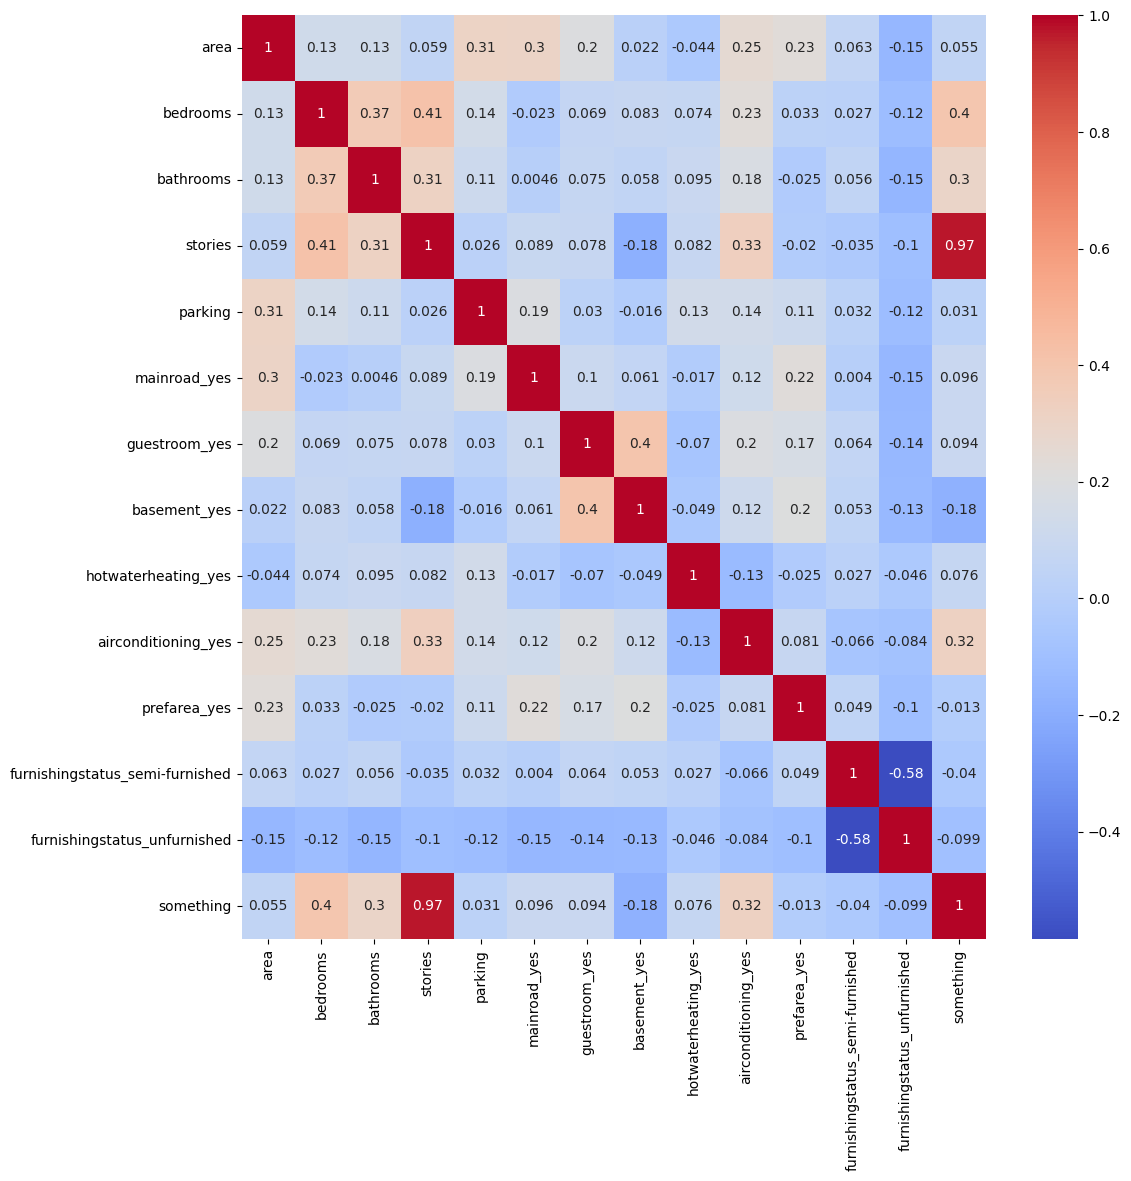

In [59]:
# Постройте корреляционную матрицу для X_housing_extended_train_scaled (corr)

plt.figure(figsize=(12, 12))
sns.heatmap(X_housing_extended_train_scaled.corr(), annot=True, cmap='coolwarm')
plt.show()

In [60]:
# Рассчитайте VIF в X_housing_extended_train_scaled для всех признаков и определите наличие мультиколлинеарности

vif_data = pd.DataFrame()
vif_data['feature'] = X_housing_extended_train_scaled.columns
vif_data['VIF'] = [variance_inflation_factor(X_housing_extended_train_scaled.values, i) 
               for i in range(X_housing_extended_train_scaled.shape[1])]
vif_data

,feature,VIF
0,area,1.281983
1,bedrooms,1.384825
2,bathrooms,1.247479
3,stories,19.909222
4,parking,1.179879
5,mainroad_yes,3.573968
6,guestroom_yes,1.579587
7,basement_yes,2.076798
8,hotwaterheating_yes,1.117041
9,airconditioning_yes,1.819622


In [61]:
# Обучите модель reg_housing_extended
# добавляем константу
X_housing_extended_train_scaled_const = sm.add_constant(X_housing_extended_train_scaled)

# обучаем OLS
reg_housing_extended = sm.OLS(y_housing_train, X_housing_extended_train_scaled_const).fit()

# сравниваем summary
print("===== ИСХОДНАЯ МОДЕЛЬ =====")
print(reg_housing.summary())
print("\n===== МОДЕЛЬ С something =====")
print(reg_housing_extended.summary())

===== ИСХОДНАЯ МОДЕЛЬ =====
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     46.60
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           3.00e-65
Time:                        21:47:27   Log-Likelihood:                -4965.2
No. Observations:                 327   AIC:                             9958.
Df Residuals:                     313   BIC:                         1.001e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

# Задание 8
Постройте корреляционную матрицу (метод corr) для обучающей выборки после добавления фактора something (X_housing_extended_train_scaled) и выберите из списка значение корреляции между факторами stories и something.

Результат округлён до 2-х знаков после запятой.
 

0.90
0.91
0.92
0.93
0.94
0.95
0.96
**0.97**
0.98
0.99

# Рассчитайте VIF для всех признаков в обучающей выборке после добавления фактора something (X_housing_extended_train_scaled) и сделайте выводы о наличии мультиколлинеарности.

Выберите все верные утверждения из списка.

-- В данных отсутствует мультиколлинеарность.  
++ Признаки stories и something сильно коррелируют (мультиколлинеарность).  
-- Признаки area и something сильно коррелируют (мультиколлинеарность).  
++ VIF для area приблизительно равен 1.28 (с точностью до 0.01).  
++ Наблюдается смещение коэффициентов регресcии: коэффициент при факторе stories при добавлении фактора something увеличивается более, чем на 100 тыс. (см. summary моделей).  

In [62]:
f = 3.198e+05 - 4.527e+05
print(f*(-1))

132900.0


### **Гетероскедастичность и тест Уайта**

**Гетероскедастичность** — это нарушение одной из ключевых предпосылок классической линейной регрессии, которое заключается в том, что дисперсия (разброс) остатков модели не является постоянной для всех наблюдений.

**Последствия гетероскедастичности:**

* Неэффективность МНК-оценок — оценки, полученные с помощью метода наименьших квадратов (МНК), не являются наиболее точными.

* Смещённость и несостоятельность ковариационной матрицы МНК-оценок. Это приводит к тому, что статистические выводы о качестве полученных оценок (t-тесты, F-тест и доверительные интервалы) могут быть неадекватными.

**Выявление гетероскедастичности:**

* Графики остатков регрессии. В первом приближении наличие гетероскедастичности можно выявить на графиках остатков регрессии по некоторым переменным, по оцененной зависимой переменной или по номеру наблюдения: разброс точек может меняться в зависимости от значения этих переменных. 

* Статистические тесты Уайта, Голдфелда-Квандта, Бройша-Пагана, Парка, Глейзера, Спирмена. 

**Тест Уайта** — это один из наиболее часто применяемых статистических тестов для обнаружения гетероскедастичности, преимущество которого заключается в том, что он не требует заранее предполагать, от чего именно зависит дисперсия ошибки. Суть этого теста заключается в проверке, существует ли статистически значимая связь между квадратами остатков исходной модели и факторами, а также их квадратами и попарными произведениями.

**Тест Уайта:**

1. Оценивается исходная регрессия и вычисляются её остатки ($e$).

2. Строится вспомогательная регрессия квадратов остатков ($e^2$) на исходные признаки, их квадраты и попарные произведения.

3. Проверяется гипотеза:

    * $H_0$: гетероскедастичности нет (гомоскедастичность, дисперсия ошибок постоянна).
    
    * $H_1$: гетероскедастичность присутствует.

### ***Задание 9***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку из задания 3: `X_housing_train_scaled`, `y_housing_train`.

* Обученную модель statsmodels из задания 4: `reg_housing`.

Посчитайте остатки регрессии `reg_housing` и постройте графики их распределения.

Проверьте наличие гетероскедастичности в данных модели `reg_housing` с помощью теста Уайта на уровне значимости 5% ([het_white](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_white.html)).

In [63]:
# Посчитайте остатки регрессии reg_housing

reg_housing_res = reg_housing.resid

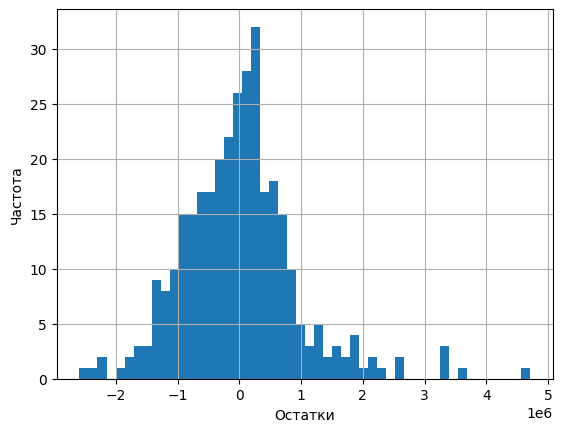

In [64]:
# Постройте график распределения остатков регрессии

plt.xlabel('Остатки')
plt.ylabel('Частота')
reg_housing_res.hist(bins=50);

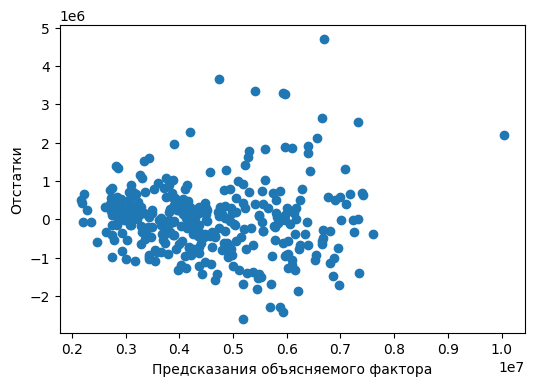

In [65]:
# Постройте график распределения остатков reg_housing в зависимости от предсказанных значений (fitted values)

plt.figure(figsize=(6, 4))
plt.xlabel('Предсказания объясняемого фактора')
plt.ylabel('Отстатки')
plt.scatter(
    x=reg_housing.fittedvalues, 
    y=reg_housing_res
)
plt.show()

In [66]:
# Выполните тест Уайта

housing_white_test = het_white(reg_housing_res, 
                               sm.add_constant(X_housing_train_scaled))

housing_white_test_result = pd.DataFrame(
    np.round(housing_white_test, 6), 
    index=['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value'], 
    columns=['Value']
)
housing_white_test_result

,Value
Test Statistic,157.381324
Test Statistic p-value,0.000046
F-Statistic,2.290022
F-Test p-value,0.000000


## Задание 9
Проверьте наличие гетероскедастичности в данных модели reg_housing с помощью теста Уайта на уровне значимости 5%.

Выберите все верные утверждения из списка.

-- По результатам теста Уайта можно утверждать, что дисперсия ошибок постоянна.  
++ Результаты теста Уайта указывают на наличие гетероскедастичности.  
-- p-value для теста Уайта больше 0.01.  
++ p-value для теста Уайта меньше 0.0001  

### **Датасет *Diabetes dataset***

**Для решения задания 10 рассмотрим датасет [Diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).**

Этот маленький датасет (442 наблюдения) предназначен для решения задачи регрессии. Его основная цель — предсказать прогрессирование диабета у пациента через год на основе диагностических показателей. 

Целевая переменная — числовой показатель, отражающий степень прогрессирования диабета.

Набор содержит 10 числовых признаков, которые были предварительно стандартизированы: 

* age — возраст.

* sex — пол.

* bmi — индекс массы тела (BMI).

* bp — среднее артериальное давление.

* s1 (tc) — общий холестерин сыворотки крови (Total Serum Cholesterol).

* s2 (ldl) — липопротеины низкой плотности (Low-Density Lipoproteins, "плохой" холестерин).

* s3 (hdl) — липопротеины высокой плотности (High-Density Lipoproteins, "хороший" холестерин).

* s4 (tch) — общий холестерин / HDL.

* s5 (ltg) — логарифм уровня триглицеридов в сыворотке крови (Log of Serum Triglycerides Level).

* s6 (glu) — уровень глюкозы в крови.

### **Методы регуляризации: Ridge, LASSO**

При обучении линейных регрессионных моделей часто возникают две проблемы: переобучение (модель слишком хорошо подстраивается под обучающие данные и плохо работает на новых) и мультиколлинеарность (сильная корреляция между факторами). 

**Регуляризация** — это метод, который позволяет бороться с этими проблемами путем добавления штрафа за сложность модели к ее функции потерь. Суть метода заключается в том, чтобы заставить модель не только минимизировать ошибку предсказания, но и удерживать коэффициенты при факторах небольшими. 

Рассмотрим два ключевых метода регуляризации: LASSO (L1-регуляризация) и Ridge (L2-регуляризация).

**LASSO (Least Absolute Shrinkage and Selection Operator)**

Функция потерь LASSO:

$$J(\theta)=\text{MSE}(\theta) + \alpha \sum_{i=1}^{k}|\theta_i|$$

где $\text{MSE}(\theta)$ — среднеквадратичная ошибка, $\theta_i$ — коэффициент при $i$-том факторе модели, $\alpha$ (альфа) — гиперпараметр, контролирующий силу штрафа.

LASSO-регрессия способна полностью обнулять коэффициенты при наименее важных факторах. Таким образом, LASSO не только уменьшает сложность модели, но и выполняет отбор наиболее важных признаков.

Если в данных есть группа сильно скоррелированных факторов, LASSO имеет тенденцию произвольно выбирать один из них, а остальные обнулять.

**Ridge-регрессия**

Функция потерь Ridge:

$$J(\theta)=\text{MSE}(\theta) + \alpha \sum_{i=1}^{k}\theta_i^2$$
    
Ridge-регрессия уменьшает абсолютные значения коэффициентов, что делает модель более устойчивой, особенно при наличии мультиколлинеарности. Важная особенность L2-штрафа в том, что он лишь уменьшает коэффициенты, стремясь к нулю, но никогда не обнуляет их полностью. Таким образом, в модели остаются все факторы.

### ***Задание 10***

Выполните предобработку датасета (см. код задания) и обучите три линейных регрессии sklearn:

* `reg_diab` — регрессия без регуляризации (LinearRegression).

* `lasso_diab` — регрессия с L1-регуляризацией (LASSO). Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV.

* `ridge_diab` — регрессия с L2-регуляризацией (Ridge). Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV.

Для каждой из моделей выведите metrics_report на тестовой выборке и определите признаки, которые были исключены из регрессии L1-регуляризацией (LASSO).

In [67]:
# Загрузите набор данных с помощью sklearn.datasets и выделите объясняемый фактор в отдельную переменную

df_diab = datasets.load_diabetes()
X_diab = pd.DataFrame(df_diab.data)
X_diab.columns = df_diab.feature_names
y_diab = df_diab.target

In [68]:
X_diab

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [69]:
# Нормализуйте значение целевой переменной

y_diab = (y_diab - y_diab.min()) / (y_diab.max() - y_diab.min())

In [70]:
# Разделите датасет на обучающую (75%) и тестовую (25%) выборки (с перемешиванием, без стратификации)
# Не забудьте зафиксировать RANDOM_STATE

X_diab_train, X_diab_test, y_diab_train, y_diab_test = train_test_split(X_diab, y_diab, test_size=0.25, random_state=42, shuffle=True)

In [71]:
# Обучите линейную регрессию без регуляризации reg_diab и выведите metrics_report на тестовой выборке

reg_diab = LinearRegression()
reg_diab.fit(X_diab_train, y_diab_train)
y_pred_diab = reg_diab.predict(X_diab_test)
metrics_report(y_diab_test, y_pred_diab)

R2 score: 0.4849
RMSE: 0.1663
MAPE: 0.5800


In [72]:
# Обучите модель lasso_diab (LASSO) и выведите metrics_report на тестовой выборке
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
cv = 5

# Подбор оптимального alpha для LASSO
cv_lasso_diab = GridSearchCV(
    Lasso(RANDOM_STATE),
    params,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

cv_lasso_diab.fit(X_diab_train, y_diab_train)
lasso_diab = cv_lasso_diab.best_estimator_

# Предсказание и отчет
y_pred_lasso = lasso_diab.predict(X_diab_test)
metrics_report(y_diab_test, y_pred_lasso)

R2 score: 0.4888
RMSE: 0.1656
MAPE: 0.6067


In [73]:
# Обучите модель ridge_diab (Ridge) и выведите metrics_report на тестовой выборке
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
cv = 5

# Подбор оптимального alpha для Ridge
cv_ridge_diab = GridSearchCV(
    Ridge(RANDOM_STATE),
    params,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
cv_ridge_diab.fit(X_diab_train, y_diab_train)

# Лучшая модель Ridge
ridge_diab = cv_ridge_diab.best_estimator_

# Предсказание и отчет
y_pred_ridge = ridge_diab.predict(X_diab_test)
metrics_report(y_diab_test, y_pred_ridge)

R2 score: 0.4854
RMSE: 0.1662
MAPE: 0.5791


In [74]:
# Рассмотрите коэффициенты моделей

diab_coefs = pd.DataFrame({
    'reg_diab coef': reg_diab.coef_,
    'lasso_diab coef': lasso_diab.coef_,
    'ridge_diab coef': ridge_diab.coef_
}, index=X_diab.columns
)

In [75]:
print(diab_coefs)

     reg_diab coef  lasso_diab coef  ridge_diab coef
age       0.148753         0.000000         0.150722
sex      -0.753866        -0.000000        -0.751627
bmi       1.657231         1.624945         1.661965
bp        1.188669         0.747969         1.185017
s1       -2.861380        -0.000000        -2.539839
s2        1.583358        -0.000000         1.332569
s3        0.364331        -0.506267         0.221193
s4        0.839540         0.000000         0.794404
s5        2.167627         1.082734         2.044033
s6        0.082008         0.000000         0.085685


## Задание 10
Выберите все верные утверждения из списка.

-- Обычная линейная регрессия (reg_diab) показала самый высокий R² на тестовой выборке.  
-- В модели ridge_diab (Ridge-регрессия) есть несколько факторов, коэффициенты при которых равны нулю, то есть эти факторы были исключены из регрессии после применения L2-регуляризации.  
++ Коэффициент при факторе bmi почти не изменяется (равен с точностью до 0.05) при применении L1 или L2 регуляризации (по сравнению с reg_diab).  
-- L2-регуляризация (по сравнению с reg_diab) почти не изменяет коэффициент при факторе s3 (равен с точностью до 0.05).  
++ Модель ridge_diab (Ridge-регрессия) на тестовой выборке показала наилучший результат с точки зрения R², RMSE, MAPE.  

**Определите факторы, коэффициенты при которых равны нулю (факторы исключены из регрессии) после обучения модели lasso_diab с L1-регуляризацией (LASSO).**

Выберите все факторы из списка, коэффициенты при которых равны нулю.  

Нулевыми считайте коэффициенты, отображающиеся в таблице diab_coefs как 0.000000 или -0.000000.  

++ age  
++ sex  
bmi  
bp  
++ s1  
++ s2  
s3  
++ s4  
s5  
++ s6  